# <font color='red'> Exploratory Data Analysis and Preprocessing for a Jobs Dataset</font> 

# <font color='green'>Introduction to the Jobs Dataset: Overview and Initial Exploration<font>

### installs 

In [9]:
!pip install wordcloud
# !pip install pycountry
# !pip install geopandas

### Imports

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from geopy.geocoders import Nominatim

### Load Dataset

In [93]:
with open('jobs.csv', 'rb') as f:
    result = chardet.detect(f.read())

df = pd.read_csv('jobs.csv', encoding=result['encoding'])

###  the number of rows and columns 

In [94]:
df.shape

(3198, 8)

we have 3198 row and 8 features

### The 5 frist and last  samples of the dataset

In [95]:
df.head()

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,"
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,NaN,90K+ *,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,"
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,"
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi..."


In [96]:
df.tail()

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
3193,Western Digital,Data Scientist - New College Graduate,"Biñan, Philippines",Full Time,Entry-level,39K+ *,"APIs,Clustering,Computer Science,Data visualiz...","Career development,,,,"
3194,Experian,Cloud Data Analyst,"Heredia, Costa Rica",Full Time,Senior-level,92K+ *,"AWS,Big Data,Computer Science,GCP,Snowflake,SQL","Equity,Medical leave,Salary bonus,,"
3195,Locus Robotics,"Robotics Engineer, Sensors","Wilmington, MA, United States",Full Time,Senior-level,62K+ *,"E-commerce,Engineering,Linux,Python,Robotics,S...",",,,,"
3196,ATB Financial,Data Scientist,"Edmonton, Alberta, Canada",Full Time,Entry-level,39K+ *,"Computer Science,Data Analytics,Data Mining,Ec...","Career development,Startup environment,,,"
3197,Shippeo,Senior Data Engineer,"Paris, France",Full Time,Senior-level,115K+ *,"Airflow,Architecture,BigQuery,CI/CD,Computer S...",",,,,"


Upon initial inspection using `df.head()`, it's evident that our dataset contains NaN values, particularly in certain columns. Additionally, the 'Salary' column requires some form of transformation to address the issue with the `K` notation . Furthermore, the 'Facilities' column have in some  rows ',,,,' as values, indicating a potential need for cleaning .

### Basic Informations about our dataset

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company                    3197 non-null   object
 1   Job Title                  3197 non-null   object
 2   Location                   3197 non-null   object
 3   Job Type                   3197 non-null   object
 4   Experience level           2962 non-null   object
 5   Salary                     3009 non-null   object
 6   Requirment of the company  3198 non-null   object
 7   Facilities                 3198 non-null   object
dtypes: object(8)
memory usage: 200.0+ KB


All features in the dataset are currently labeled as object type. Regarding the 'Salary' column, its type and format will require transformation for accurate analysis.

In [98]:
df.nunique()

Company                      1106
Job Title                    2138
Location                     1117
Job Type                        3
Experience level                4
Salary                        218
Requirment of the company    2600
Facilities                    777
dtype: int64

In [99]:
df.isnull().sum()

Company                        1
Job Title                      1
Location                       1
Job Type                       1
Experience level             236
Salary                       189
Requirment of the company      0
Facilities                     0
dtype: int64

# <font color='green'>Cleaning & Preprocessing <font>

As we can see ,our dataset contains missing values, particularly in the 'Experience level' and 'Salary' columns. The code cell below  to calculate the percentage of missing values in each column.
Since the count of missing values is small (1 for each column), we may consider removing the rows with missing values using.

In [100]:
# Drop rows with missing values in specified columns
df = df.dropna(subset=['Company', 'Job Title', 'Location', 'Job Type'])
df.isnull().sum()

Company                        0
Job Title                      0
Location                       0
Job Type                       0
Experience level             235
Salary                       188
Requirment of the company      0
Facilities                     0
dtype: int64

Now, let's address the 'Experience level' column. Our suggestion is to initially fill in 'Experience level' values for rows where we have a valid 'Salary'.
Subsequently, we can infer the 'Experience level' based on the salary values, completing the missing labels for the remaining rows.

In [101]:
# Convert 'Salary' to numeric format
df['Salary'] = pd.to_numeric(df['Salary'].str.replace('[^\d.]', '', regex=True), errors='coerce')

# Define the number of quantiles or bins for salary ranges
num_quantiles = 4  # as we have 4 experience levels

# Create salary ranges using qcut
df['Salary Range'] = pd.qcut(df['Salary'], q=num_quantiles, labels=False)

# Map quantile labels to experience levels
experience_levels = ['Entry-level', 'Mid-level', 'Senior-level', 'Executive-level']
# Iterate over rows
for index, row in df.iterrows():
    # Check if 'Experience level' is null
    if pd.isnull(row['Experience level']):
        # Check if 'Salary' is not null
        if not pd.isnull(row['Salary']):
            # Map 'Salary' to 'Experience level'
            df.at[index, 'Experience level'] = experience_levels[int(row['Salary Range'])]
# Drop the temporary 'Salary Range' column
df = df.drop(columns=['Salary Range'])

# Display the updated DataFrame
print(df[['Experience level']])




     Experience level
0         Entry-level
1         Entry-level
2        Senior-level
3         Entry-level
4           Mid-level
...               ...
3193      Entry-level
3194     Senior-level
3195     Senior-level
3196      Entry-level
3197     Senior-level

[3197 rows x 1 columns]


In [102]:
df.isnull().sum()

Company                        0
Job Title                      0
Location                       0
Job Type                       0
Experience level               3
Salary                       188
Requirment of the company      0
Facilities                     0
dtype: int64

Now, let's handle the 'Salary' column. We propose a similar logic, calculating the mean salary for each 'Experience level'.
When encountering a row with a valid 'Experience level' but a missing 'Salary', we fill the 'Salary' with the mean of that specific 'Experience level'.


In [103]:
# Iterate over rows
for index, row in df.iterrows():
    # Check if 'Salary' is null
    if pd.isnull(row['Salary']):
        # Check if 'Experience level' is not null
        if not pd.isnull(row['Experience level']):
            # Calculate the mean salary for the 'Experience level' range
            mean_salary = df[df['Experience level'] == row['Experience level']]['Salary'].mean()
            # Fill the null 'Salary' with the calculated mean salary
            df.at[index, 'Salary'] = mean_salary

# Display the updated DataFrame
print(df[['Experience level', 'Salary']])


     Experience level  Salary
0         Entry-level    48.0
1         Entry-level    48.0
2        Senior-level    90.0
3         Entry-level    48.0
4           Mid-level   108.0
...               ...     ...
3193      Entry-level    39.0
3194     Senior-level    92.0
3195     Senior-level    62.0
3196      Entry-level    39.0
3197     Senior-level   115.0

[3197 rows x 2 columns]


In [104]:
df.isnull().sum()

Company                      0
Job Title                    0
Location                     0
Job Type                     0
Experience level             3
Salary                       3
Requirment of the company    0
Facilities                   0
dtype: int64

As observed, we currently have only 3 remaining null values in the dataset. It's safe to proceed by removing these rows now.


In [105]:
# Drop rows with null values
df = df.dropna()
df[:5]

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48.0,"Computer Science,Data quality,Genetics,Mathema...",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48.0,"Agile,Data management,Finance,Security,,",",,,,"
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,Senior-level,90.0,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,"
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48.0,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,"
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108.0,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi..."


We observe an issue in the 'Facilities' column, where numerous entries contain a sequence of commas (',,,'). To address this, a straightforward solution involves replacing these occurrences with the label 'Not Specified' for better clarity and uniformity.

In [106]:
# replace the values with ,,,, in the Facilities column with 'Not Specified'
df['Facilities'].replace(',,,,', 'Not-Specified,', inplace=True)
# remove , if it is succeeded by a , in the Facilities column
df['Facilities'] = df['Facilities'].str.replace(r',,', ',')
df['Facilities'] = df['Facilities'].str.replace(r',,,', ',')
df['Facilities'] = df['Facilities'].str.replace(r',,,,', ',')
df['Facilities'] = df['Facilities'].str.replace(r',,,', ',')
df['Facilities'] = df['Facilities'].str.replace(r',,', ',')
# remove , if it is in the end of the string in the Facilities column
df['Facilities'] = df['Facilities'].str.replace(r',$', '')
df['Facilities']

0                                          Not-Specified,
1                                          Not-Specified,
2                                     Career development,
3                                          Not-Specified,
4       Flex hours,Flex vacation,Parental leave,Unlimi...
                              ...                        
3193                                  Career development,
3194                   Equity,Medical leave,Salary bonus,
3195                                       Not-Specified,
3196              Career development,Startup environment,
3197                                       Not-Specified,
Name: Facilities, Length: 3194, dtype: object

In [107]:
num_duplicates = df.duplicated().sum()
print(f'The number of duplicate rows in the DataFrame is: {num_duplicates}')


The number of duplicate rows in the DataFrame is: 197


The subsequent code cell provides a detailed display of the exact duplicated rows.

In [108]:
df[df.duplicated()]

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
100,Shopify,"Staff Engineer, Data Platform","Austin, TX, United States",Full Time,Senior-level,62.000000,"AWS,Azure,BigQuery,Computer Science,Dataflow,D...","Not-Specified,"
698,Netcentric,(Senior) Digital Analytics Engineer,"Barcelona, Spain",Full Time,Senior-level,110.000000,"A/B testing,Angular,APIs,Computer Science,Engi...","Career development,Fitness / gym,Flex hours,Fl..."
804,NBCUniversal,Sr. Data Engineer,"New York, NEW YORK, United States",Full Time,Senior-level,115.000000,"Agile,Airflow,Architecture,Big Data,Computer S...","Flex hours,Health care,Insurance,Medical leave,"
807,Metiora,Data Analyst Intern,"Madrid, Spain",Full Time,Entry-level,50.319654,"Matplotlib,MongoDB,NumPy,Pandas,Power BI,Python","Not-Specified,"
815,Civis Analytics,Lead Applied Data Scientist (Experience with M...,Remote,Full Time,Senior-level,104.847114,"Causal inference,Computer Science,Consulting,D...","401(k) matching,Career development,Competitive..."
...,...,...,...,...,...,...,...,...
3184,Brightspeed,"Senior Data Engineer, Customer Data Platform","Charlotte, NC, United States",Full Time,Senior-level,115.000000,"Agile,CX,Data warehouse,ELT,ETL,GCP","Competitive pay,Equity,Health care,Salary bonu..."
3189,6point6,Data Analyst,"London, United Kingdom",Full Time,Mid-level,75.000000,"Agile,Architecture,Big Data,Data analysis,Engi...","Career development,Competitive pay,Equity,Flex..."
3194,Experian,Cloud Data Analyst,"Heredia, Costa Rica",Full Time,Senior-level,92.000000,"AWS,Big Data,Computer Science,GCP,Snowflake,SQL","Equity,Medical leave,Salary bonus,"
3195,Locus Robotics,"Robotics Engineer, Sensors","Wilmington, MA, United States",Full Time,Senior-level,62.000000,"E-commerce,Engineering,Linux,Python,Robotics,S...","Not-Specified,"


first let's delete duplicated rows 

In [109]:
df = df.drop_duplicates()

In [110]:
df.shape

(2997, 8)

for the location column we will try to add a column based on the it for countries

In [114]:
# By using .loc[:, 'Country'], we re explicitly telling Pandas to modify the original DataFrame rather than a temporary slice
df.loc[:, 'Country'] = df['Location'].str.split(',').str[-1].str.strip()

# Display the updated DataFrame
df[:10]


,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities,Country
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48.000000,"Computer Science,Data quality,Genetics,Mathema...","Not-Specified,",United States
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48.000000,"Agile,Data management,Finance,Security,,","Not-Specified,",Mauritius
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,Senior-level,90.000000,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,",United States
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48.000000,"Engineering,Industrial,Oracle,Power BI,R,R&D","Not-Specified,",Italy
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108.000000,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi...",United States
5,ServiceNow,Sr Staff Data Scientist - ATG,"Kirkland, Washington, United States",Full Time,Senior-level,184.000000,"Computer Science,Deep Learning,Industrial,Mach...","401(k) matching,Career development,Competitive...",United States
6,Natixis in Portugal,Vendor Management and Data Quality Lead,"Porto, Portugal",Full Time,Entry-level,39.000000,"Banking,Data quality,Excel,Security,,","Gear,",Portugal
7,NielsenIQ,Intern (Business Intelligence Service Support),"Bangkok, Thailand",Internship,Entry-level,50.319654,"Business Intelligence,Excel,Genetics,,,","Not-Specified,",Thailand
8,Western Digital,Summer 2023 Data Engineering Intern,"San Jose, CA, United States",Internship,Entry-level,50.319654,"Big Data,Computer Science,Engineering,Machine ...","Career development,Competitive pay,Equity,Flex...",United States
9,Palo Alto Networks,Principal Cloud Data Engineer (Prisma Access),"Santa Clara, CA, United States",Full Time,Senior-level,140.000000,"Agile,APIs,AWS,Azure,Big Data,Computer Science","Career development,Medical leave,Salary bonus,...",United States


# <font color='green'>Vizualisation and analysis<font>

### Salaries analysis

In [431]:
# Multiply 'Salary' column by 1000
df['Salary'] = df['Salary'] * 1000

# Display the updated DataFrame
print(df[['Salary']])


        Salary
0      48000.0
1      48000.0
2      90000.0
3      48000.0
4     108000.0
...        ...
3190  113000.0
3191  106000.0
3192  176000.0
3193   39000.0
3196   39000.0

[2997 rows x 1 columns]


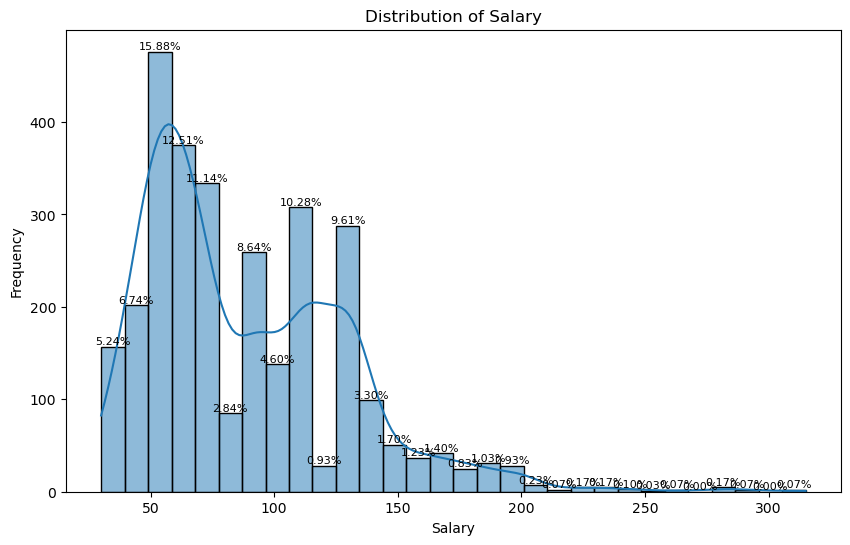

In [34]:
# Distribution of Salary with Percentage Labels
plt.figure(figsize=(10, 6))
salary_distribution = sns.histplot(df['Salary'], bins=30, kde=True)
plt.title('Distribution of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency')

# Add percentage labels
total_count = len(df['Salary'])
for bar in salary_distribution.patches:
    percentage = f"{bar.get_height() / total_count * 100:.2f}%"
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y, percentage, ha='center', va='bottom', fontsize=8)

plt.show()


Upon visualisation, it becomes evident that the majority of salaries center around the 50K range, indicating that this is the prevalent salary bracket in the dataset.

by expereince level

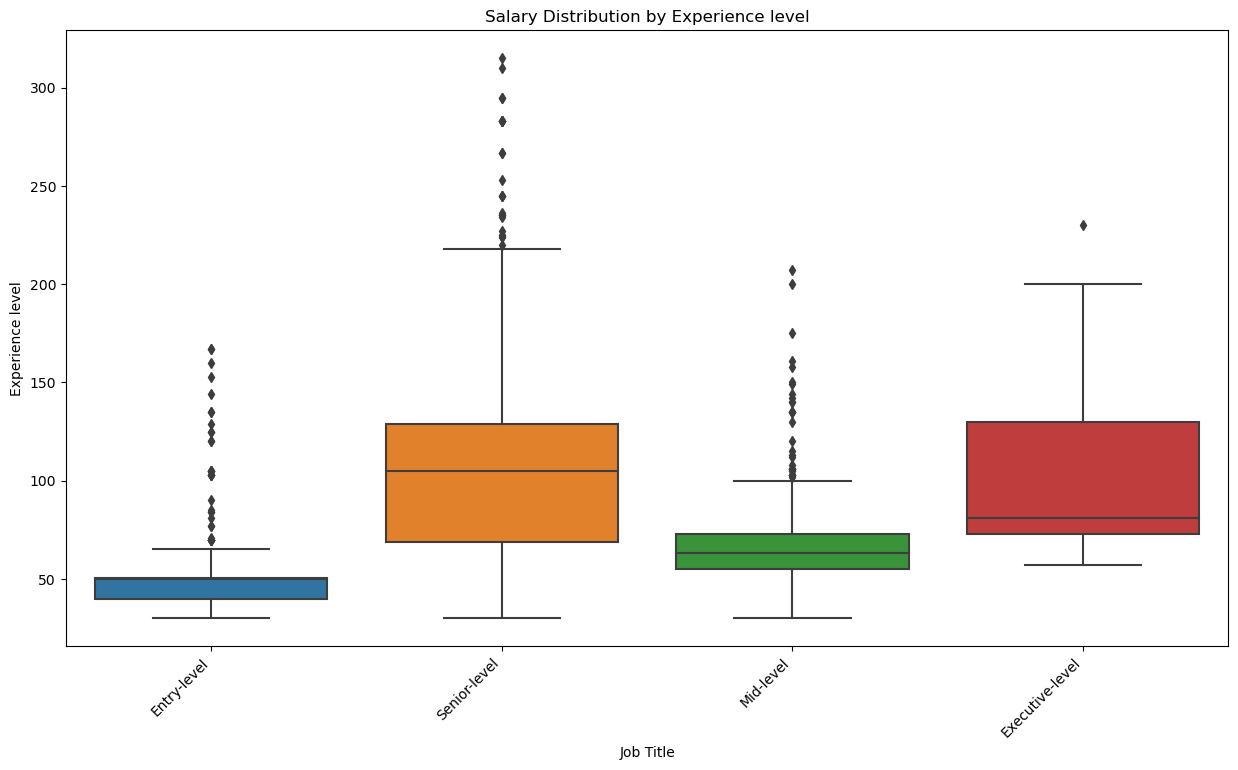

In [46]:
# Plot the salary distribution by Experience level
plt.figure(figsize=(15, 8))
sns.boxplot(x='Experience level', y='Salary', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Salary Distribution by Experience level')
plt.xlabel('Job Title')
plt.ylabel('Experience level')
plt.show()


Observing the chart, it's evident that the median salary for individuals with senior-level experience is the highest among the different experience levels. Additionally, there is a notable variance in salary distribution, indicating a broader range of salaries within this group. It's worth noting that outliers are present across all experience levels, signaling the need for careful consideration and handling of these exceptional salary values.

by Job Type

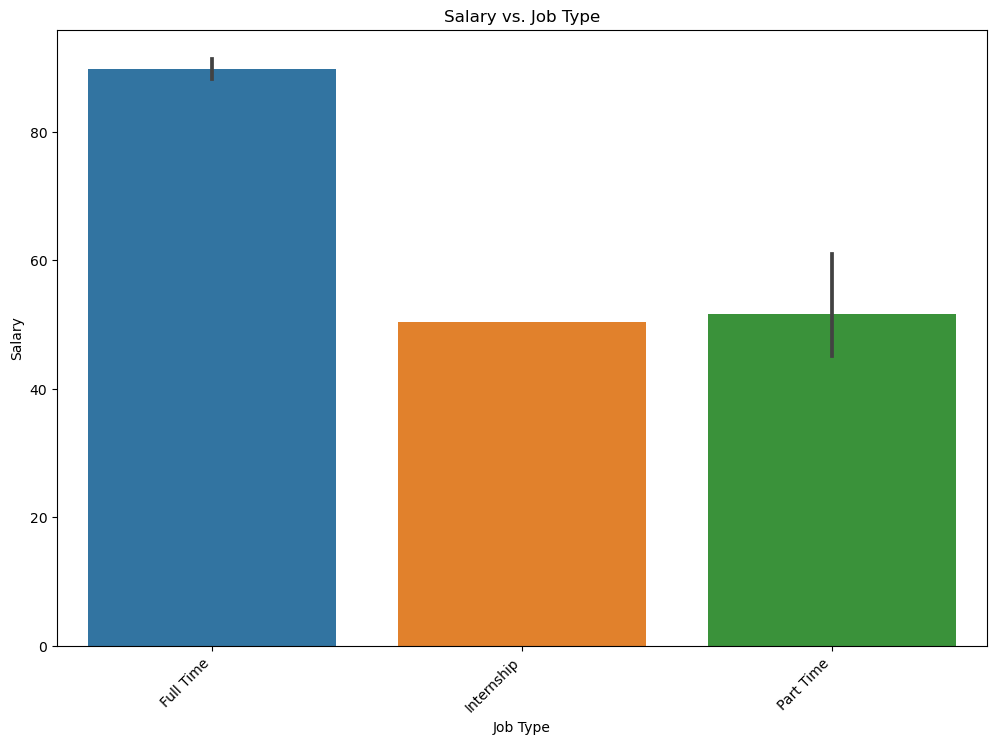

In [47]:
# Salary vs. Job Type
plt.figure(figsize=(12, 8))
sns.barplot(x='Job Type', y='Salary', data=df)
plt.title('Salary vs. Job Type')
plt.xticks(rotation=45, ha='right')
plt.show()


As observed in the bar chart, Full-time positions exhibit the highest average salary, which aligns with expectations. This insight underscores the influence of job types on salary levels, with Full-time roles generally commanding a higher average compensation compared to other job categories.

### Experience level analysis

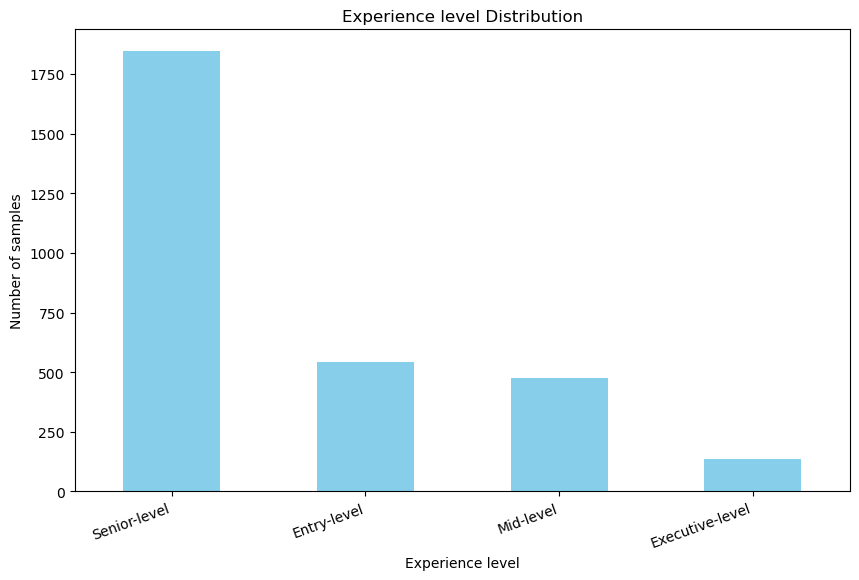

In [116]:
#count the number of occurence for each label
expereicne_lebel_counts = df['Experience level'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
expereicne_lebel_counts.plot(kind='bar', color='skyblue')
plt.title('Experience level Distribution')
plt.xlabel('Experience level')
plt.ylabel('Number of samples')
plt.xticks(rotation=20, ha='right')
plt.show()


The chart shows that companies seek candidates with senior-level experience, indicating a higher demand for individuals with extensive expertise and seasoned skills.

### Requirment of the company analysis

This Word Cloud visually represents the most prominent words in job requirements.

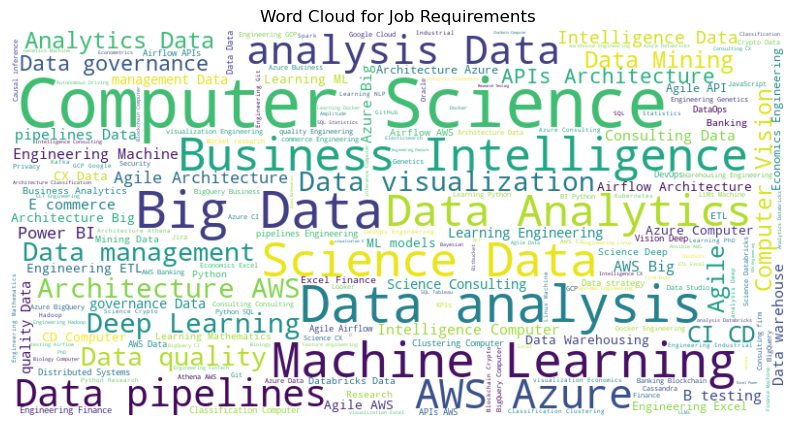

In [429]:
text_data = ' '.join(df['Requirment of the company'].dropna())

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Job Requirements')
plt.show()


The most frequently mentioned job requirements in the word cloud are Big Data, Data Analytics, Data Science, Machine Learning, Computer Sciences, Data pipelines, AWS.

In [131]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains the 'Requirment of the company' column
requirements = df['Requirment of the company']

# Tokenize and preprocess the text
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(requirements)


In [132]:
X

<2997x297 sparse matrix of type '<class 'numpy.float64'>'
	with 22029 stored elements in Compressed Sparse Row format>

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


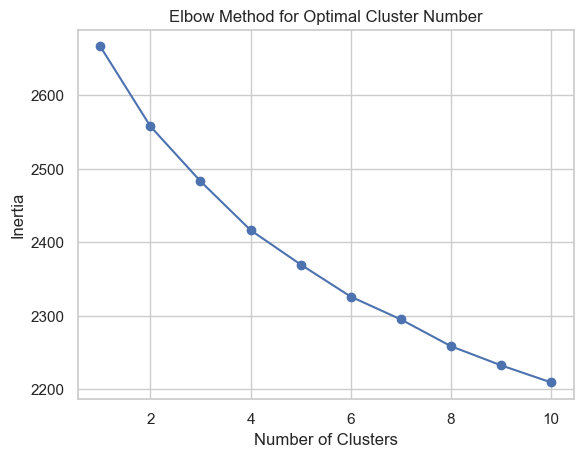

In [133]:
# Use the Elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Number')
plt.show()


In [136]:
# 'n_clusters' is the chosen number from the Elbow method
n_clusters = 3 

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Access cluster labels
cluster_labels = kmeans.labels_

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


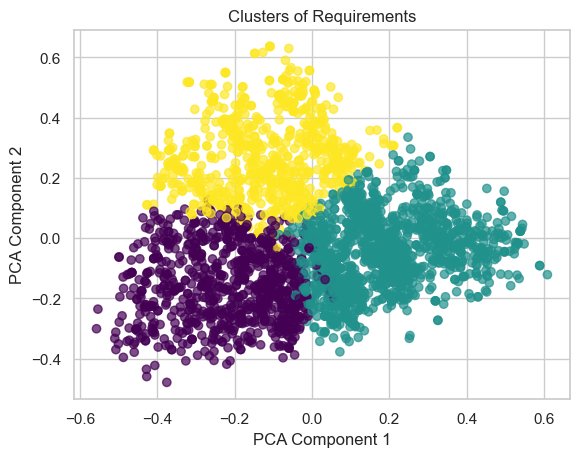

array([1, 0, 2, ..., 1, 1, 0])

In [137]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Create a scatter plot of clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Clusters of Requirements')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
cluster_labels